In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns

In [279]:
data = pd.read_excel('data_new.xlsx')
data

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,Date,DateClaimed,Date_Diff
0,12,5,3,Honda,Urban,2,1,1,Female,Single,...,No,External,none,1 year,3 to 4,1994,Liability,1994-12-29,1994-01-05,-358
1,1,3,3,Honda,Urban,1,1,4,Male,Single,...,No,External,none,no change,1 vehicle,1994,Collision,1994-01-20,1994-01-25,5
2,10,5,5,Honda,Urban,4,11,2,Male,Married,...,No,External,none,no change,1 vehicle,1994,Collision,1994-10-29,1994-11-11,13
3,6,2,6,Toyota,Rural,5,7,1,Male,Married,...,No,External,more than 5,no change,1 vehicle,1994,Liability,1994-06-12,1994-07-02,20
4,1,5,1,Honda,Urban,2,2,2,Female,Single,...,No,External,none,no change,1 vehicle,1994,Collision,1994-02-01,1994-02-09,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15414,11,4,5,Toyota,Urban,2,11,5,Male,Married,...,No,External,none,no change,1 vehicle,1996,Collision,1996-11-23,1996-12-04,11
15415,11,5,4,Pontiac,Urban,5,12,1,Male,Married,...,No,External,more than 5,no change,3 to 4,1996,Liability,1996-11-29,1996-12-07,8
15416,11,5,4,Toyota,Rural,5,12,1,Male,Single,...,No,External,1 to 2,no change,1 vehicle,1996,Collision,1996-11-29,1996-12-07,8
15417,12,1,1,Toyota,Urban,4,12,2,Female,Married,...,No,External,more than 5,no change,1 vehicle,1996,All Perils,1996-12-03,1996-12-13,10


## Data Cleaning and Feature Engineering

In [280]:
#Handle abnormal values: negative date_diff
data[data['Date_Diff']<0]['Date_Diff'].value_counts()

-5      206
-6      203
-4      169
-3      146
-2      119
       ... 
-260      1
-334      1
-271      1
-238      1
-270      1
Name: Date_Diff, Length: 183, dtype: int64

(array([3.8400e+02, 7.2000e+01, 4.0000e+01, 2.2000e+01, 5.8900e+02,
        1.4043e+04, 2.0300e+02, 3.6000e+01, 2.7000e+01, 3.0000e+00]),
 array([-368. , -295.1, -222.2, -149.3,  -76.4,   -3.5,   69.4,  142.3,
         215.2,  288.1,  361. ]),
 <BarContainer object of 10 artists>)

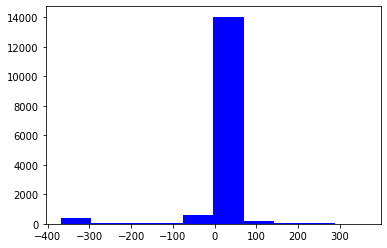

In [281]:
plt.hist(data['Date_Diff'], color='blue')

From the above histogram, we could observe that most of Date_diff values are around 0 to 100. Values less than -300 are likely to be representing that claims were made in the next year.

(array([1.3454e+04, 6.3500e+02, 1.9000e+02, 8.1000e+01, 3.5000e+01,
        4.1000e+01, 3.2000e+01, 1.6000e+01, 7.0000e+00, 9.2800e+02]),
 array([ -3. ,  33.7,  70.4, 107.1, 143.8, 180.5, 217.2, 253.9, 290.6,
        327.3, 364. ]),
 <BarContainer object of 10 artists>)

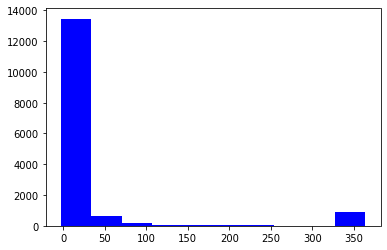

In [282]:
data.loc[data['Date_Diff'] < 0, 'Date_Diff'] += 365
plt.hist(data['Date_Diff'], color='blue')

In [283]:
outlier = data['Date_Diff']>300
data = data[~outlier] 

In [284]:
#Drop columns
data = data.drop(['Date', 'DateClaimed'], axis = 1)

In [285]:
data = data.drop(['PolicyNumber'], axis = 1)

In [286]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'RepNumber', 'Deductible',
       'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'Date_Diff'],
      dtype='object')

## Encode categorical variables

In [287]:
# Overview of distinct values of each categorical variable
categorical_val = ['Make', 'AccidentArea', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory','VehiclePrice', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']
for column in categorical_val:
    distinct_values = data[column].nunique()
    print(f"Number of distinct values for {column}: {distinct_values}")

Number of distinct values for Make: 19
Number of distinct values for AccidentArea: 2
Number of distinct values for Sex: 2
Number of distinct values for MaritalStatus: 4
Number of distinct values for Fault: 2
Number of distinct values for PolicyType: 9
Number of distinct values for VehicleCategory: 3
Number of distinct values for VehiclePrice: 6
Number of distinct values for Days_Policy_Accident: 5
Number of distinct values for Days_Policy_Claim: 3
Number of distinct values for PastNumberOfClaims: 4
Number of distinct values for AgeOfVehicle: 8
Number of distinct values for AgeOfPolicyHolder: 9
Number of distinct values for PoliceReportFiled: 2
Number of distinct values for WitnessPresent: 2
Number of distinct values for AgentType: 2
Number of distinct values for NumberOfSuppliments: 4
Number of distinct values for AddressChange_Claim: 5
Number of distinct values for NumberOfCars: 5
Number of distinct values for BasePolicy: 3


In [288]:
# Label encode binary classes
label_encoder = LabelEncoder()
binary_class = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
for column in binary_class:
    data[column] = label_encoder.fit_transform(data[column])

In [289]:
# PolicyType seems to be a combination of VehicleCategory and BasePolicy. Check any inconsistency.
combination_type = data['VehicleCategory'] + ' - ' + data['BasePolicy']
matching_values = data['PolicyType'] == combination_type

# Calculate the percentage of matching values
percentage_matching = (matching_values.sum() / len(data)) * 100
print(percentage_matching)

67.3591938155715


In [290]:
# As almost 70% of PolicyType matches the combination of VehicleCategory and BasePolicy. There is high possibility of multicollinearity. 
# Therefore, PolicyType should be dropped and an additional column is created to indicate whether the original PolicyType value matches the combination of other two columns.
data['Matching'] = matching_values.astype(int)
data = data.drop(['PolicyType'], axis = 1)

In [291]:
# Map year
data['Year'] = data['Year'].map({1994: 0, 1995: 1, 1996: 2})
data['Year']

0        0
1        0
2        0
3        0
4        0
        ..
15414    2
15415    2
15416    2
15417    2
15418    2
Name: Year, Length: 14488, dtype: int64

In [292]:
# One-Hot encoding categorical variables
onehot_variables = ['Make',
 'MaritalStatus',
 'VehicleCategory',
 'VehiclePrice',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'BasePolicy']

one_hot_encoded = pd.get_dummies(data, columns=onehot_variables)

one_hot_encoded


,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,Age,Fault,...,AddressChange_Claim_no change,AddressChange_Claim_under 6 months,NumberOfCars_1 vehicle,NumberOfCars_2 vehicles,NumberOfCars_3 to 4,NumberOfCars_5 to 8,NumberOfCars_more than 8,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,12,5,3,1,2,1,1,0,21,0,...,0,0,0,0,1,0,0,0,0,1
1,1,3,3,1,1,1,4,1,34,0,...,1,0,1,0,0,0,0,0,1,0
2,10,5,5,1,4,11,2,1,47,0,...,1,0,1,0,0,0,0,0,1,0
3,6,2,6,0,5,7,1,1,65,1,...,1,0,1,0,0,0,0,0,0,1
4,1,5,1,1,2,2,2,0,27,1,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15414,11,4,5,1,2,11,5,1,35,0,...,1,0,1,0,0,0,0,0,1,0
15415,11,5,4,1,5,12,1,1,30,0,...,1,0,0,0,1,0,0,0,0,1
15416,11,5,4,0,5,12,1,1,24,0,...,1,0,1,0,0,0,0,0,1,0
15417,12,1,1,1,4,12,2,0,34,1,...,1,0,1,0,0,0,0,1,0,0


In [293]:
len(one_hot_encoded.columns)

98

### Train-Test Split and Scaling

In [294]:
# train-test split
x = one_hot_encoded.drop(['FraudFound_P'], axis = 1)
y = one_hot_encoded['FraudFound_P']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.3, random_state=42)

In [295]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [296]:
print(Y_train.mean())
print(Y_test.mean())

0.060940735627650136
0.062341844950540605


## Model Building

In [297]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True)
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


127/127 [==============================] - 3s 8ms/step - loss: 0.3090 - accuracy: 0.9098 - val_loss: 0.2004 - val_accuracy: 0.9458
Epoch 2/100
127/127 [==============================] - 0s 4ms/step - loss: 0.2091 - accuracy: 0.9375 - val_loss: 0.1861 - val_accuracy: 0.9458
Epoch 3/100
127/127 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9377 - val_loss: 0.1828 - val_accuracy: 0.9448
Epoch 4/100
127/127 [==============================] - 0s 4ms/step - loss: 0.1850 - accuracy: 0.9381 - val_loss: 0.1798 - val_accuracy: 0.9428
Epoch 5/100
127/127 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9382 - val_loss: 0.1790 - val_accuracy: 0.9433
Epoch 6/100
127/127 [==============================] - 1s 5ms/step - loss: 0.1729 - accuracy: 0.9387 - val_loss: 0.1789 - val_accuracy: 0.9438
Epoch 7/100
127/127 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9387 - val_loss: 0.1816 - val_accuracy: 0.9399
Epoch 8/100

In [298]:
# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)

# Display training classification report and confusion matrix
print("Training Classification Report:\n", classification_report(Y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(Y_train, y_train_pred))

317/317 [==============================] - 1s 3ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      9523
           1       0.61      0.03      0.06       618

    accuracy                           0.94     10141
   macro avg       0.78      0.51      0.51     10141
weighted avg       0.92      0.94      0.91     10141

Training Confusion Matrix:
 [[9511   12]
 [ 599   19]]


It is obvious that recall for class 1 is very small. It is resulted from unbalanced dataset. 
Next, I will try to handle the unbalanced dataset with class weights.

In [299]:
class_labels = np.unique(Y_train)
class_weights = compute_class_weight(class_weight ='balanced',classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(zip(class_labels, class_weights))
# Use class weights during model training
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])


Epoch 1/100
127/127 [==============================] - 2s 8ms/step - loss: 0.5093 - accuracy: 0.7414 - val_loss: 0.5307 - val_accuracy: 0.6757
Epoch 2/100
127/127 [==============================] - 0s 4ms/step - loss: 0.4228 - accuracy: 0.7316 - val_loss: 0.5019 - val_accuracy: 0.7023
Epoch 3/100
127/127 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.7427 - val_loss: 0.5043 - val_accuracy: 0.7151
Epoch 4/100
127/127 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.7584 - val_loss: 0.4437 - val_accuracy: 0.7447
Epoch 5/100
127/127 [==============================] - 1s 7ms/step - loss: 0.3561 - accuracy: 0.7744 - val_loss: 0.4220 - val_accuracy: 0.7575
Epoch 6/100
127/127 [==============================] - 0s 3ms/step - loss: 0.3413 - accuracy: 0.7949 - val_loss: 0.3946 - val_accuracy: 0.7827
Epoch 7/100
127/127 [==============================] - 0s 3ms/step - loss: 0.3230 - accuracy: 0.8004 - val_loss: 0.3919 - val_accuracy: 0.7945

In [300]:
# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)

# Display training classification report and confusion matrix
print("Training Classification Report:\n", classification_report(Y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(Y_train, y_train_pred))

317/317 [==============================] - 1s 2ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      9523
           1       0.32      0.89      0.47       618

    accuracy                           0.88     10141
   macro avg       0.66      0.88      0.70     10141
weighted avg       0.95      0.88      0.90     10141

Training Confusion Matrix:
 [[8354 1169]
 [  71  547]]


In [301]:
# Evaluate the model on the test set using the best parameters
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

136/136 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      4076
           1       0.19      0.50      0.27       271

    accuracy                           0.83      4347
   macro avg       0.57      0.68      0.59      4347
weighted avg       0.91      0.83      0.87      4347

Confusion Matrix:
 [[3486  590]
 [ 136  135]]


In [302]:
# Reduce model complexity
model3 = Sequential()
model3.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True)

class_labels = np.unique(Y_train)
class_weights = compute_class_weight(class_weight ='balanced',classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(zip(class_labels, class_weights))
# Use class weights during model training
model3.fit(X_train, Y_train, epochs=50, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])


Epoch 1/50
127/127 [==============================] - 2s 5ms/step - loss: 0.8109 - accuracy: 0.4831 - val_loss: 0.7158 - val_accuracy: 0.5175
Epoch 2/50
127/127 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.5636 - val_loss: 0.6307 - val_accuracy: 0.5850
Epoch 3/50
127/127 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6143 - val_loss: 0.5934 - val_accuracy: 0.6220
Epoch 4/50
127/127 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.6324 - val_loss: 0.5751 - val_accuracy: 0.6471
Epoch 5/50
127/127 [==============================] - 1s 4ms/step - loss: 0.5635 - accuracy: 0.6499 - val_loss: 0.5606 - val_accuracy: 0.6599
Epoch 6/50
127/127 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.6649 - val_loss: 0.5411 - val_accuracy: 0.6703
Epoch 7/50
127/127 [==============================] - 0s 4ms/step - loss: 0.5247 - accuracy: 0.6922 - val_loss: 0.5318 - val_accuracy: 0.6777
Epoch 

In [303]:
# Evaluate the model on the training set
y_train_pred = model3.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)

# Display training classification report and confusion matrix
print("Training Classification Report:\n", classification_report(Y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(Y_train, y_train_pred))

317/317 [==============================] - 1s 1ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      9523
           1       0.19      0.92      0.31       618

    accuracy                           0.75     10141
   macro avg       0.59      0.83      0.58     10141
weighted avg       0.94      0.75      0.82     10141

Training Confusion Matrix:
 [[7083 2440]
 [  51  567]]


In [304]:
# Evaluate the model on the test set using the best parameters
y_pred = model3.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

 16/136 [==>...........................] - ETA: 0s 

136/136 [==============================] - 1s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      4076
           1       0.15      0.73      0.25       271

    accuracy                           0.72      4347
   macro avg       0.56      0.73      0.54      4347
weighted avg       0.92      0.72      0.79      4347

Confusion Matrix:
 [[2950 1126]
 [  73  198]]


Try another method, SMOTE to solve the issue.

SMOTE can generate synthetic samples for the minority class to balance the class distribution. 

In [305]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and transform the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

In [306]:
y_train_resampled.mean()

0.5

In [307]:
model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
239/239 [==============================] - 1s 6ms/step - loss: 0.2629 - accuracy: 0.8941 - val_loss: 0.2887 - val_accuracy: 0.9178
Epoch 2/100
239/239 [==============================] - 1s 4ms/step - loss: 0.2336 - accuracy: 0.9073 - val_loss: 0.2757 - val_accuracy: 0.9189
Epoch 3/100
239/239 [==============================] - 1s 4ms/step - loss: 0.2145 - accuracy: 0.9176 - val_loss: 0.2357 - val_accuracy: 0.9394
Epoch 4/100
239/239 [==============================] - 1s 4ms/step - loss: 0.1998 - accuracy: 0.9229 - val_loss: 0.2043 - val_accuracy: 0.9504
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.1887 - accuracy: 0.9301 - val_loss: 0.2267 - val_accuracy: 0.9386
Epoch 6/100
239/239 [==============================] - 1s 3ms/step - loss: 0.1742 - accuracy: 0.9355 - val_loss: 0.2405 - val_accuracy: 0.9244
Epoch 7/100
239/239 [==============================] - 1s 4ms/step - loss: 0.1648 - accuracy: 0.9394 - val_loss: 0.1845 - val_accuracy: 0.9517

In [308]:
# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)

# Display training classification report and confusion matrix
print("Training Classification Report:\n", classification_report(Y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(Y_train, y_train_pred))

317/317 [==============================] - 0s 1ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9523
           1       0.73      0.99      0.84       618

    accuracy                           0.98     10141
   macro avg       0.87      0.98      0.91     10141
weighted avg       0.98      0.98      0.98     10141

Training Confusion Matrix:
 [[9299  224]
 [   9  609]]


In [309]:
# Evaluate the model on the test set using the best parameters
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

136/136 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      4076
           1       0.15      0.20      0.17       271

    accuracy                           0.88      4347
   macro avg       0.55      0.56      0.55      4347
weighted avg       0.90      0.88      0.89      4347

Confusion Matrix:
 [[3768  308]
 [ 216   55]]


The recall on test set is very low, indicating an overfitting issue.

Next step is to solve the issue by restricting the model complexity.

In [310]:
# Add dropout, reduce a layer and reduce epochs
model2 = Sequential()
model2.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True)
model2.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
239/239 [==============================] - 2s 4ms/step - loss: 0.6272 - accuracy: 0.6592 - val_loss: 0.7173 - val_accuracy: 0.6008
Epoch 2/20
239/239 [==============================] - 1s 3ms/step - loss: 0.4966 - accuracy: 0.7465 - val_loss: 0.6149 - val_accuracy: 0.7669
Epoch 3/20
239/239 [==============================] - 1s 3ms/step - loss: 0.4507 - accuracy: 0.7770 - val_loss: 0.5849 - val_accuracy: 0.7871
Epoch 4/20
239/239 [==============================] - 1s 3ms/step - loss: 0.4277 - accuracy: 0.7908 - val_loss: 0.5501 - val_accuracy: 0.8205
Epoch 5/20
239/239 [==============================] - 1s 3ms/step - loss: 0.4134 - accuracy: 0.7978 - val_loss: 0.5264 - val_accuracy: 0.8375
Epoch 6/20
239/239 [==============================] - 1s 3ms/step - loss: 0.3959 - accuracy: 0.8103 - val_loss: 0.4961 - val_accuracy: 0.8546
Epoch 7/20
239/239 [==============================] - 1s 2ms/step - loss: 0.3825 - accuracy: 0.8183 - val_loss: 0.5210 - val_accuracy: 0.8323
Epoch 

In [311]:
# Evaluate the model on the training set
y_train_pred = model2.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)

# Display training classification report and confusion matrix
print("Training Classification Report:\n", classification_report(Y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(Y_train, y_train_pred))

317/317 [==============================] - 1s 2ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      9523
           1       0.33      0.80      0.47       618

    accuracy                           0.89     10141
   macro avg       0.66      0.85      0.70     10141
weighted avg       0.95      0.89      0.91     10141

Training Confusion Matrix:
 [[8502 1021]
 [ 121  497]]


In [312]:
# Evaluate the model on the test set using the best parameters
y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

136/136 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      4076
           1       0.17      0.40      0.24       271

    accuracy                           0.84      4347
   macro avg       0.56      0.64      0.58      4347
weighted avg       0.91      0.84      0.87      4347

Confusion Matrix:
 [[3557  519]
 [ 163  108]]


In [313]:
# Build a simple neural network model
def build_model():
    model3 = Sequential()
    model3.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(1, activation='sigmoid'))
    model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model3

# Initialize StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store results
optimal_thresholds = []
f1_scores = []

# Perform cross-validated predictions
for train_index, test_index in kfold.split(X_train, Y_train):
    x_train, X_validation = X_train[train_index], X_train[test_index]
    y_train, y_validation = Y_train.iloc[train_index], Y_train.iloc[test_index]

    model = build_model()

    early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True)

    class_labels = np.unique(y_train)
    class_weights = compute_class_weight(class_weight ='balanced',classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(zip(class_labels, class_weights))
    # Use class weights during model training
    model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])


    # Predict probabilities on the test set
    y_pred_prob = model.predict(X_validation)

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_validation, y_pred_prob)

    # Calculate F1 score for each threshold
    f1_scores_fold = 2 * (precision * recall) / (precision + recall)

    # Handle cases where both precision and recall are zero
    f1_scores_fold = np.nan_to_num(f1_scores_fold, nan=0.0)

    # Find the threshold that maximizes F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores_fold)]

    # Append results to lists
    optimal_thresholds.append(optimal_threshold)
    f1_scores.append(np.max(f1_scores_fold))

# Calculate average optimal threshold and F1 score
avg_optimal_threshold = np.mean(optimal_thresholds)
avg_f1_score = np.mean(f1_scores)

# Print average optimal threshold and F1 score
print("Average Optimal Threshold:", avg_optimal_threshold)
print("Average F1 Score at Optimal Threshold:", avg_f1_score)

Epoch 1/50
115/115 [==============================] - 2s 8ms/step - loss: 0.8596 - accuracy: 0.5193 - val_loss: 0.7169 - val_accuracy: 0.5367
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5718 - val_loss: 0.6359 - val_accuracy: 0.5942
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6097 - val_loss: 0.6231 - val_accuracy: 0.6150
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6270 - val_loss: 0.5909 - val_accuracy: 0.6435
Epoch 5/50
115/115 [==============================] - 0s 3ms/step - loss: 0.5871 - accuracy: 0.6447 - val_loss: 0.5745 - val_accuracy: 0.6522
Epoch 6/50
115/115 [==============================] - 0s 3ms/step - loss: 0.5502 - accuracy: 0.6604 - val_loss: 0.5479 - val_accuracy: 0.6714
Epoch 7/50
115/115 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.6823 - val_loss: 0.5413 - val_accuracy: 0.6769
Epoch 

In [314]:
model3 = Sequential()
model3.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True)

class_labels = np.unique(Y_train)
class_weights = compute_class_weight(class_weight ='balanced',classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(zip(class_labels, class_weights))
# Use class weights during model training
model3.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])


Epoch 1/20
127/127 [==============================] - 2s 5ms/step - loss: 0.8777 - accuracy: 0.5068 - val_loss: 0.7087 - val_accuracy: 0.5589
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5907 - val_loss: 0.6394 - val_accuracy: 0.6008
Epoch 3/20
127/127 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6112 - val_loss: 0.6012 - val_accuracy: 0.6333
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 0.5934 - accuracy: 0.6370 - val_loss: 0.5884 - val_accuracy: 0.6407
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.5551 - accuracy: 0.6493 - val_loss: 0.5559 - val_accuracy: 0.6555
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 0.5270 - accuracy: 0.6731 - val_loss: 0.5353 - val_accuracy: 0.6629
Epoch 7/20
127/127 [==============================] - 1s 5ms/step - loss: 0.5480 - accuracy: 0.6641 - val_loss: 0.5222 - val_accuracy: 0.6718
Epoch 

In [318]:
# Evaluate the model on the training set
y_train_pred = model3.predict(X_train)
# set threshold to be 0.64
y_train_pred = (y_train_pred > 0.65).astype(int)

# Display training classification report and confusion matrix
print("Training Classification Report:\n", classification_report(Y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(Y_train, y_train_pred))

  1/317 [..............................] - ETA: 10s

317/317 [==============================] - 2s 5ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      9523
           1       0.22      0.75      0.34       618

    accuracy                           0.82     10141
   macro avg       0.60      0.79      0.62     10141
weighted avg       0.93      0.82      0.86     10141

Training Confusion Matrix:
 [[7869 1654]
 [ 156  462]]


In [317]:
# Evaluate the model on the test set using the best parameters
y_pred = model3.predict(X_test)
y_pred = (y_pred > 0.65).astype(int)

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

  1/136 [..............................] - ETA: 6s

136/136 [==============================] - 1s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88      4076
           1       0.16      0.58      0.26       271

    accuracy                           0.79      4347
   macro avg       0.57      0.69      0.57      4347
weighted avg       0.92      0.79      0.84      4347

Confusion Matrix:
 [[3283  793]
 [ 115  156]]
